<a href="https://colab.research.google.com/github/AlexTako/cancer/blob/main/Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Для постановки задачи я использовал статью с сайта [Webiomed](https://webiomed.ru/)  который специализируется на задачах использования искусственного интелекта в медицине. Что примечательно, webiomed имеет регистрационное удостоверение Росздравнадзора на медицинские изделия с искусственным интелектом. Заинтересовала именно статья об открытых источниках различных наборов данных касательно медицины: [Статья](https://webiomed.ru/blog/obzor-otkrytykh-istochnikov-dannykh-meditsinskikh-izobrazhenii-dlia-mashinnogo-obucheniia/).

Среди источников на глаза попался интересный [веб архив](https://www.cancerimagingarchive.net/browse-collections/). На данном ресурсе представлены архивы изображений различных медицинских исследований.

В качестве подопытного возьмем архив с данными МРТ исследований груди с контрастом для выявления рака груди на ранних стадиях

В качестве библиотеки для построения модели, воспользуемся XGBoost во взаимодействии с SKLearn. Данная библиотека хорошо себя показала с точки зрения производительности и скорости работы

In [ ]:
#устанавливаем пакеты
!pip install xgboost==0.90 # Сама библиотека XGBoost
!pip install pandas # Для работы с датасетами
!pip install scikit-learn # sklearn у которой мы позаимствуем несколько классов по исследованию точности, построения графиков и т.д.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 MB 2.5 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.3
    Uninstalling xgboost-2.0.3:
      Successfully uninstalled xgboost-2.0.3


In [ ]:
#импорт библиотек
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from matplotlib.pylab import rc, plot
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

In [ ]:
# импортируем наш датасет
data = pd.read_excel('/content/Advanced-MRI-Breast-Lesions.xlsx', sheet_name=0, header=1)
data.head()

,Patient ID,age at MRI,reason for referral ID#,additional reason for referral ID#,breast implants,BIRADS,tumor/benign1,pos1,pathology1,GRADE1,...,KI67[%] 3,tumor/benign4,pos4,pathology4,tumor/benign5,pos5,pathology5,tumor/benign6,pos6,pathology6
0,AMBL-001,47.4,2,5,0,4,1.0,L-60.85,9.0,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AMBL-002,41.3,3,NaN,1,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AMBL-003,53.3,6,NaN,0,6,1.0,R-2.76,1.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AMBL-004,51.3,3,NaN,1,2,0.0,L-51.98,11.0,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AMBL-005,75.3,3,5,0,4,1.0,R-28.46,3.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Здесь мы можем обратить внимание что имеют место быть пропущенные значения, а также некоторые данные которые не понадобятся для дальнейшего анализа. Необходимо подготовить данные для дальнейшего обучения нашей модели. Также можно обратить внимание что исследование у некоторых пациентов было проведено не один раз.

In [ ]:
# Работаем с данными
data = data.drop(['Patient ID', 'pos1', 'pos2', 'pos3', 'pos4', 'pos5', 'pos6'], axis= 1) # Эти данные нам не нужны для обработки
data = data.fillna(0)
data.head()

,age at MRI,reason for referral ID#,additional reason for referral ID#,breast implants,BIRADS,tumor/benign1,pathology1,GRADE1,ER [SII] 1,PR [SII] 1,...,PR [%] 3,HER [%] 3,Unnamed: 43,KI67[%] 3,tumor/benign4,pathology4,tumor/benign5,pathology5,tumor/benign6,pathology6
0,47.4,2,5,0,4,1.0,9.0,-1,-1,-1,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,41.3,3,0,1,2,0.0,0.0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,53.3,6,0,0,6,1.0,1.0,3,-1,-1,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,51.3,3,0,1,2,0.0,11.0,-1,-1,-1,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,75.3,3,5,0,4,1.0,3.0,2,2.9,1.4,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
replace_dict = {
    'additional reason for referral ID#': {'only 6 min delay': 0, 'severe motion in delayed series': 0},
    'BIRADS': {'4A': 4, '3, 4A': 3},
    'GRADE1': {'1 to 2': 1.5, '2 to 3': 2.5, '2 to3': 2.5},
    'GRADE2': {'1 to 2': 1.5, '2 to 3': 2.5, '2 to3': 2.5},
    'ER [SII] 1': {'weak ': 1, 'moderate ': 2, 'strong': 3, 'neg': 0, 'Moderate to strong': 2.5, 'pos': 1, 'moderate': 2, 'weak': 1, 'weak to moderate': 1.5},
    'PR [SII] 1': {'weak ': 1, 'strong': 3, 'neg': 0, 'Moderate to strong': 2.5, 'pos': 1, 'moderate': 2, 'weak': 1, 'weak to moderate': 1.5, 'moderate to strong': 2.5},
    'HER2 [SII] 1': {'weak ': 1, 'neg': 0, 'pos': 1, 'strong': 3, 'weak': 1},
    'KI67[%] 1': {'high': 70, 'low': 20, 'intermediate': 50, 'low to intermediate': 35, 'intermediate to high': 75, '60 to 70': 65, '30 to 40': 35, '10 to 20': 15, '3 to 5': 4, '15 to 20': 17.5, 'Intermediate': 50, '5 to 10': 7.5, '6 to 9': 8, '20 to 25': 23, '50 to 60': 55, 'Intermediate to high': 75, '2 to 3': 2.5},
    'ER [SII] 2': {'strong': 3, 'neg': 0, 'Moderate to strong': 2.5, 'weak': 1},
    'PR [SII] 2': {'strong': 3, 'neg': 0, 'weak': 1, 'intermediate': 2},
    'HER2 [SII] 2': {'neg': 0, 'strong': 3},
    'KI67[%] 2': {'Intermediate': 50, 'intermediate': 50, 'high': 70, 'low to intermediate': 35, 'intermediate to high': 75, 'high to intermediate': 75, '30 to 40': 35, '2 to 3': 2.5},
    'ER [SII] 3': {'strong': 3},
    'PR [SII] 3': {'strong': 3, 'weak': 1},
    'HER [SII] 3': {'neg': 0},
    'KI67[%] 3': {'low to intermediate': 35},
    'ER [%] 1': {'2 to 3': 2.5},
    'PR [%] 1': {'2 to 3': 2.5}
}
data = data.replace(replace_dict)

In [ ]:
 pathology_data = data[['pathology1']].copy()
signs_data = data.drop(['pathology1', 'pathology2', 'pathology3', 'pathology4', 'pathology5', 'pathology6'], axis= 1)
pathology = np.array(pathology_data, dtype= int) # создаем признак патологии который кодирован в диапазоне от 0 до 25
signs = np.array(signs_data)
scale_signs = StandardScaler().fit_transform(signs)

In [ ]:
# Делим выборку на обучающую и тестовую
signs_train, signs_test, pathology_train, pathology_test = train_test_split(scale_signs, pathology, train_size= 0.8)

In [ ]:
# Строим модель обучения используя clasifier от XGBoost
model = xgb.XGBClassifier()

In [ ]:
# Обучение
model.fit(signs_train, pathology_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


XGBClassifier(objective='multi:softprob')

In [ ]:
# Оценка точности
model.score(signs_test, pathology_test)

0.775

У меня получилось набрать только 77,5 % точности, но датасет сам по себе не очень большой

In [ ]:
  pred = model.predict(signs_test)
print(pred)

[ 1 17  0  1 22  1 17  1 17  4  1 15  0  0  0  1  1  1  1  1  3 11  0  0
  5 11  0 11  1  0 15 11  1  0  1  1  0  1  1  1]


#Расшифровка значений
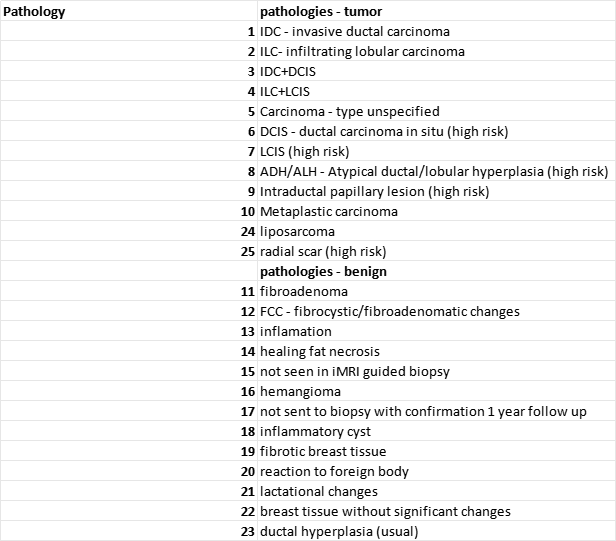

Confusion matrix, without normalization
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  5  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]]


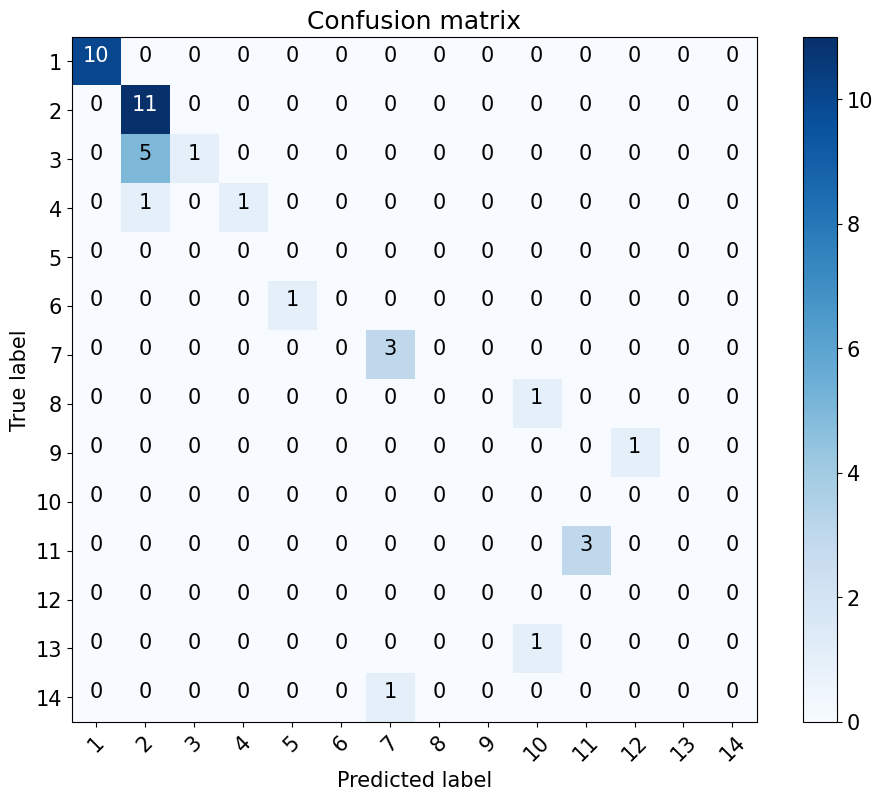

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(pathology_test, model.predict(signs_test))
plt.figure(figsize=(10, 8))
cls = []
for i in range(14):
    cls.append(str(i + 1))
plot_confusion_matrix(cnf_matrix, classes=cls,
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

#Подведем итоги:
Я выбрал не самый лучший набор данных, так как он имеет мало данных и эти данные не были однородными, однако, удалось добиться средней точности.

По матрице точности мы видим что модель предсказывает значения, но из-за малого количества дынных требует дальнейшего обучения